In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nab:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F110%2F240%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240718%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240718T072530Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0faf423699b93b808860a79fa49ff58a7d260485abce818f0d61b6d28dcd9a600fbc2b64e5d8f025026c44aa73d59405df50d86170a63298d0b7db4e1df540b683cab92430371d6a15e4b4e607ddd801fc587c340819c1322073bfc1cbd1b3b8a7b8e8ae2602f8dbfb599846c5b93de821c72b69ca02acaffad0a09f51726c56b2875b711cae6b1e1d9d4cd29efd59ca71ce1d90a9f03fafd02fe61bee08472e562eb71865cd33a0aea44af233f1732c64218af412b2130f62a662f0dab8e6a40c639387fa1a2acca7be3c32a590bd59055e738e3b612bb6a93874d73858b3e4410261da3abe702e1a22dc9205361fafe906e3236f806fa2f75cd596aac9e756'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


PermissionError: [WinError 5] Access is denied: '/kaggle'

<h2 style="text-align:center;font-size:200%;;">Industrial  Machine Anomaly Detection</h2>
<h3  style="text-align:center;">Keywords : <span class="label label-success">IoT</span> <span class="label label-success">Anomaly Detection</span> <span class="label label-success">Model Interpretability</span> <span class="label label-success">Model Comparison</span></h3>

# Table of Contents<a id='top'></a>
>1. [Overview](#1.-Overview)  
>    * [Project Detail](#Project-Detail)
>    * [Goal of this notebook](#Goal-of-this-notebook)
>1. [Import libraries](#2.-Import-libraries)
>1. [Load the dataset](#3.-Load-the-dataset)
>1. [Pre-processing](#4.-Pre-processing)
>    * [Anomaly Points](#Anomaly-Points)
>    * [Datetime Information](#Datetime-Information)
>1. [EDA](#5.-EDA)  
>    * [Basic Analysis](#Basic-Analysis)
>    * [Time Series Analysis](#Time-Series-Analysis)
>1. [Modeling](#6.-Modeling)
>    * [Model1. Hotelling's T2](#Model1.-Hotelling's-T2)
>    * [Model2. One-Class SVM](#Model2.-One\-Class-SVM)
>    * [Model3. Isolation Forest](#Model3.-Isolation-Forest)
>    * [Model4. LOF](#Model4.-LOF)
>    * [Model5. ChangeFinder](#Model5.-ChangeFinder)
>    * [Model6. Variance Based Method](#Model6.-Variance-Based-Method)
>    * [Model Comparison](#Model-Comparison)
>1. [Conclusion](#7.-Conclusion)
>1. [References](#8.-References)

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 1. Overview
## Project Detail
>In this project, we use [NAB-dataset](https://www.kaggle.com/boltzmannbrain/nab), which is a novel benchmark for evaluating algorithms for anomaly detection in several fields.  
>There are 58 timeseries data from various kind of sources.
>* **Real data**
>    * realAWSCloudwatch
>    * realAdExchange
>    * realKnownCause
>    * realTraffic
>    * realTweets
>* **Artificial data**
>    * artificialNoAnomaly
>    * artificialWithAnomaly
>
>In these dataset above, I picked up and analyzed **'machine_temperature_system_failure'** from realKnownCause dataset based on my buissiness interests.  
>This dataset does not include acutual anomaly point, so we need to refer to the [NAB github page](https://github.com/numenta/NAB/blob/master/labels/combined_windows.json).

## Goal of this notebook
>* Practice data pre-processing technique
>* Practice EDA technique to deal with time-series data
>* Practice visualising technique
>* Practice anomaly detection modeling technique
>    * from simple techniques to complex techniques
>* Practice improving model interpretability technique
>    * SHAP

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 2. Import libraries

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
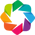

C:\Users\ksfach\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from matplotlib import pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import changefinder
from sklearn.metrics import f1_score
from tabulate import tabulate
from IPython.display import HTML, display
import shap
shap.initjs()


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 3. Load the dataset
>As above, we use 'machine_temperature_system_failure.csv' for our analysis.  
>According to dataset information, it has the following features :
>* Temperature sensor data of an internal component of a large, industrial mahcine.
>* The first anomaly is a planned shutdown of the machine.
>* The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/nab/realKnownCause/realKnownCause'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv("../data/machine_temperature_system_failure.csv",low_memory=False)
print(f'machine_temperature_system_failure.csv : {df.shape}')
df.head(3)

machine_temperature_system_failure.csv : (22695, 2)


timestamp      value
0  2013-12-02 21:15:00  73.967322
1  2013-12-02 21:20:00  74.935882
2  2013-12-02 21:25:00  76.124162

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 4. Pre-processing

## Anomaly Points
>We can get anomaly points information [here](https://github.com/numenta/NAB/blob/master/labels/combined_windows.json)

In [4]:
anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
        ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
]


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
#is anomaly? : True => 1, False => 0
df['anomaly'] = 0
for start, end in anomaly_points:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1

## Datetime Information

In [6]:
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

In [7]:
df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head(3)

value  anomaly  year  month  day  hour  minute
timestamp                                                              
2013-12-02 21:15:00  73.967322        0  2013     12    2    21      15
2013-12-02 21:20:00  74.935882        0  2013     12    2    21      20
2013-12-02 21:25:00  76.124162        0  2013     12    2    21      25

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 5. EDA

## Basic Analysis

In [8]:
count = hv.Bars(df.groupby(['year','month'])['value'].count()).opts(ylabel="Count", title='Year/Month Count')
mean = hv.Bars(df.groupby(['year','month']).agg({'value': ['mean']})['value']).opts(ylabel="Temperature", title='Year/Month Mean Temperature')
(count + mean).opts(opts.Bars(width=380, height=300,tools=['hover'],show_grid=True, stacked=True, legend_position='bottom'))

C:\Users\ksfach\AppData\Roaming\Python\Python311\site-packages\holoviews\plotting\bokeh\chart.py:931: RuntimeWarning: divide by zero encountered in divide
  width /= xdiff
C:\Users\ksfach\AppData\Roaming\Python\Python311\site-packages\holoviews\plotting\bokeh\chart.py:931: RuntimeWarning: divide by zero encountered in divide
  width /= xdiff


:Layout
   .Bars.I  :Bars   [year,month]   (value)
   .Bars.II :Bars   [year,month]   (mean)

In [9]:
year_maxmin = df.groupby(['year','month']).agg({'value': ['min', 'max']})
(hv.Bars(year_maxmin['value']['max']).opts(ylabel="Temperature", title='Year/Month Max Temperature') \
+ hv.Bars(year_maxmin['value']['min']).opts(ylabel="Temperature", title='Year/Month Min Temperature'))\
    .opts(opts.Bars(width=380, height=300,tools=['hover'],show_grid=True, stacked=True, legend_position='bottom'))

C:\Users\ksfach\AppData\Roaming\Python\Python311\site-packages\holoviews\plotting\bokeh\chart.py:931: RuntimeWarning: divide by zero encountered in divide
  width /= xdiff
C:\Users\ksfach\AppData\Roaming\Python\Python311\site-packages\holoviews\plotting\bokeh\chart.py:931: RuntimeWarning: divide by zero encountered in divide
  width /= xdiff


:Layout
   .Bars.I  :Bars   [year,month]   (max)
   .Bars.II :Bars   [year,month]   (min)

In [10]:
hv.Distribution(df['value']).opts(opts.Distribution(title="Temperature Distribution", xlabel="Temperature", ylabel="Density", width=700, height=300,tools=['hover'],show_grid=True))

:Distribution   [value]   (Density)

In [11]:
((hv.Distribution(df.loc[df['year']==2013,'value'], label='2013') * hv.Distribution(df.loc[df['year']==2014,'value'], label='2014')).opts(title="Temperature by Year Distribution", legend_position='bottom') + \
(hv.Distribution(df.loc[df['month']==12,'value'], label='12') * hv.Distribution(df.loc[df['month']==1,'value'], label='1') \
     * hv.Distribution(df.loc[df['month']==2,'value'], label='2')).opts(title="Temperature by Month Distribution", legend_position='bottom')) \
     .opts(opts.Distribution(xlabel="Temperature", ylabel="Density", width=380, height=300,tools=['hover'],show_grid=True))

:Layout
   .Overlay.I  :Overlay
      .Distribution.A_2013 :Distribution   [value]   (Density)
      .Distribution.A_2014 :Distribution   [value]   (Density)
   .Overlay.II :Overlay
      .Distribution.A_12 :Distribution   [value]   (Density)
      .Distribution.A_1  :Distribution   [value]   (Density)
      .Distribution.A_2  :Distribution   [value]   (Density)

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Time Series Analysis

>plot temperature & its given anomaly points.

In [9]:
anomalies = [[ind, value] for ind, value in zip(df[df['anomaly']==1].index, df.loc[df['anomaly']==1,'value'])]
(hv.Curve(df['value'], label="Temperature") * hv.Points(anomalies, label="Anomaly Points").opts(color='red', legend_position='bottom', size=2, title="Temperature & Given Anomaly Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature     :Curve   [timestamp]   (value)
   .Points.Anomaly_Points :Points   [x,y]

In [10]:
hv.Curve(df['value'].resample('D').mean()).opts(opts.Curve(title="Temperature Mean by Day", xlabel="Time", ylabel="Temperature", width=700, height=300,tools=['hover'],show_grid=True))

:Curve   [timestamp]   (value)

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 6. Modeling
>We will build several anomaly detection models and compare them each other.

## Model1. Hotelling's T2
><div class="alert alert-info" role="alert">
><ul>
><li>Basic anomaly detection method based on statustics.</li>
></ul>
></div>

In [11]:
hotelling_df = pd.DataFrame()
hotelling_df['value'] = df['value']
mean = hotelling_df['value'].mean()
std = hotelling_df['value'].std()
hotelling_df['anomaly_score'] = [((x - mean)/std) ** 2 for x in hotelling_df['value']]
hotelling_df['anomaly_threshold'] = stats.chi2.ppf(q=0.95, df=1)
hotelling_df['anomaly']  = hotelling_df.apply(lambda x : 1 if x['anomaly_score'] > x['anomaly_threshold'] else 0, axis=1)

In [12]:
(hv.Curve(hotelling_df['anomaly_score'], label='Anomaly Score') * hv.Curve(hotelling_df['anomaly_threshold'], label='Threshold').opts(color='red', line_dash="dotdash")) \
  .opts(title="Hotelling's T2 - Anomaly Score & Threshold", xlabel="Time", ylabel="Anomaly Score", legend_position='bottom').opts(opts.Curve(width=700, height=400, show_grid=True, tools=['hover']))

:Overlay
   .Curve.Anomaly_Score :Curve   [timestamp]   (anomaly_score)
   .Curve.Threshold     :Curve   [timestamp]   (anomaly_threshold)

In [13]:
anomalies = [[ind, value] for ind, value in zip(hotelling_df[hotelling_df['anomaly']==1].index, hotelling_df.loc[hotelling_df['anomaly']==1,'value'])]
(hv.Curve(hotelling_df['value'], label="Temperature") * hv.Points(anomalies, label="Detected Points").opts(color='red', legend_position='bottom', size=2, title="Hotelling's T2 - Detected Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature      :Curve   [timestamp]   (value)
   .Points.Detected_Points :Points   [x,y]

In [14]:
hotelling_f1 = f1_score(df['anomaly'], hotelling_df['anomaly'])
print(f'Hotelling\'s T2 F1 Score : {hotelling_f1}')

Hotelling's T2 F1 Score : 0.5440778799351


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Model2. One-Class SVM
><div class="alert alert-info" role="alert">
><ul>
><li>Unsupervised kernel-based anomaly detection method.</li>
></ul>
></div>

In [24]:
ocsvm_model = OneClassSVM(nu=0.2, gamma=0.001, kernel='rbf')
ocsvm_ret = ocsvm_model.fit_predict(df['value'].values.reshape(-1, 1))
ocsvm_df = pd.DataFrame()
ocsvm_df['value'] = df['value']
ocsvm_df['anomaly']  = [1 if i==-1 else 0 for i in ocsvm_ret]

In [25]:
anomalies = [[ind, value] for ind, value in zip(ocsvm_df[ocsvm_df['anomaly']==1].index, ocsvm_df.loc[ocsvm_df['anomaly']==1,'value'])]
(hv.Curve(ocsvm_df['value'], label="Temperature") * hv.Points(anomalies, label="Detected Points").opts(color='red', legend_position='bottom', size=2, title="One-Class SVM - Detected Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature      :Curve   [timestamp]   (value)
   .Points.Detected_Points :Points   [x,y]

In [26]:
ocsvm_f1 = f1_score(df['anomaly'], ocsvm_df['anomaly'])
print(f'One-Class SVM F1 Score : {ocsvm_f1}')

One-Class SVM F1 Score : 0.4224441833137485


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Model3. Isolation Forest
><div class="alert alert-info" role="alert">
><ul>
><li>Unsupervised tree-based anomaly detection method.</li>
></ul>
></div>

In [36]:
import joblib

iforest_model = IsolationForest(n_estimators=300, contamination=0.1, max_samples='auto')
data = df['value'].values.reshape(-1, 1)

train_size = int(len(data) * 0.8)
train_data = data[:train_size]

iforest_ret = iforest_model.fit_predict(train_data)
iforest_df = pd.DataFrame()
iforest_df['value'] = df['value']
iforest_df['anomaly']  = [1 if i==-1 else 0 for i in iforest_ret]

iforest_df.head(25)

iforest_df_anomalies = iforest_df[iforest_df['anomaly'] == 1]

# Print the filtered rows
print(iforest_df_anomalies)
total_anomalies = iforest_df['anomaly'].sum()
print("Total number of anomalies:", total_anomalies)
# iforest_df_anomalies.to_csv('../data/pred_anomalies.csv')


joblib.dump(iforest_model, '../models/Isolation1.keras')
# save_model(iforest_model, '../models/Isolation1.pkl')

                          value  anomaly
timestamp                               
2013-12-04 00:40:00   62.873392        1
2013-12-04 01:00:00   62.357190        1
2013-12-04 01:05:00   61.941243        1
2013-12-04 01:10:00   62.199629        1
2013-12-04 01:15:00   61.913398        1
...                         ...      ...
2014-02-15 15:40:00  102.782028        1
2014-02-15 15:45:00  102.913657        1
2014-02-15 16:00:00  103.041769        1
2014-02-15 16:15:00  102.332493        1
2014-02-15 16:30:00  102.712131        1

[2270 rows x 2 columns]
Total number of anomalies: 2270


['../models/Isolation1.keras']

In [22]:
# import pickle

# def save_model(clf, filename):
#     with open(filename, 'wb') as f:
#         pickle.dump(clf, f)

import joblib

joblib.dump(ocsvm_model, 'ocsvm_model.keras')

In [35]:
anomalies = [[ind, value] for ind, value in zip(iforest_df[iforest_df['anomaly']==1].index, iforest_df.loc[iforest_df['anomaly']==1,'value'])]
(hv.Curve(iforest_df['value'], label="Temperature") * hv.Points(anomalies, label="Detected Points").opts(color='red', legend_position='bottom', size=2, title="Isolation Forest - Detected Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature      :Curve   [timestamp]   (value)
   .Points.Detected_Points :Points   [x,y]

In [19]:
sample_train = df['value'].values[np.random.randint(0, len(df['value']), (100))].reshape(-1, 1)
explainer = shap.TreeExplainer(model=iforest_model, feature_perturbation="interventional", data=sample_train)
shap_values = explainer.shap_values(X=sample_train)
shap.summary_plot(shap_values=shap_values, features=sample_train, feature_names=['value'], plot_type="violin")

IndexError: index -2 is out of bounds for axis 0 with size 1

In [21]:
iforest_f1 = f1_score(df['anomaly'], iforest_df['anomaly'])
print(f'Isolation Forest F1 Score : {iforest_f1}')

Isolation Forest F1 Score : 0.5143234905244601


In [26]:
data = pd.read_csv('../data/Synthetic_Dataset.csv')
timestamps = pd.to_datetime(data['timestamp'])
values = data['value'].tolist()

if_model = pickle.load(open('../models/Isolation.pkl', 'rb'))

In [31]:
def preprocess_data(data):
        # Ensure the data is reshaped to the expected input shape of (num_samples, num_features)
        data_array = np.array(data).reshape((-1, 1))
        return data_array

def calculate_reconstruction_loss(original, reconstruction):
    # Mean Absolute Error
    reconstruction_loss = np.mean(np.abs(original - reconstruction), axis=1)
    return reconstruction_loss

def detect_anomalies(data):
    preprocessed_data = preprocess_data(data)
    reconstruction = if_model.predict(preprocessed_data)
    reconstruction_loss = calculate_reconstruction_loss(preprocessed_data, reconstruction)
    print(reconstruction_loss)

In [32]:
detect_anomalies(values)
# print(anomalies, reconstruction_losses)

[ 80.77249595 107.61833367  83.52809598 ... 103.51259407  86.88750246
 102.593372  ]


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Model4. LOF
><div class="alert alert-info" role="alert">
><ul>
><li>Unsupervised density-based anomaly detection method, which measures the local deviation of density of a given sample with respect to its neighbors.</li>
></ul>
></div>

In [ ]:
lof_model = LocalOutlierFactor(n_neighbors=500, contamination=0.07)
lof_ret = lof_model.fit_predict(df['value'].values.reshape(-1, 1))
lof_df = pd.DataFrame()
lof_df['value'] = df['value']
lof_df['anomaly']  = [1 if i==-1 else 0 for i in lof_ret]

In [ ]:
anomalies = [[ind, value] for ind, value in zip(lof_df[lof_df['anomaly']==1].index, lof_df.loc[lof_df['anomaly']==1,'value'])]
(hv.Curve(lof_df['value'], label="Temperature") * hv.Points(anomalies, label="Detected Points").opts(color='red', legend_position='bottom', size=2, title="LOF - Detected Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature      :Curve   [timestamp]   (value)
   .Points.Detected_Points :Points   [x,y]

In [ ]:
lof_f1 = f1_score(df['anomaly'], lof_df['anomaly'])
print(f'LOF F1 Score : {lof_f1}')

LOF F1 Score : 0.3577910292973813


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Model5. ChangeFinder
><div class="alert alert-info" role="alert">
><ul>
><li>Change detection method based on SDAR model.</li>
></ul>
></div>

In [ ]:
cf_model = changefinder.ChangeFinder(r=0.002, order=1, smooth=250)
ch_df = pd.DataFrame()
ch_df['value'] = df['value']
ch_df['anomaly_score'] = [cf_model.update(i) for i in ch_df['value']]
ch_score_q1 = stats.scoreatpercentile(ch_df['anomaly_score'], 25)
ch_score_q3 = stats.scoreatpercentile(ch_df['anomaly_score'], 75)
ch_df['anomaly_threshold'] = ch_score_q3 + (ch_score_q3 - ch_score_q1) * 3
ch_df['anomaly']  = ch_df.apply(lambda x : 1 if x['anomaly_score'] > x['anomaly_threshold'] else 0, axis=1)

In [ ]:
(hv.Curve(ch_df['anomaly_score'], label='Anomaly Score') * hv.Curve(ch_df['anomaly_threshold'], label='Threshold').opts(color='red', line_dash="dotdash")) \
  .opts(title="ChangeFinder - Anomaly Score & Threshold", xlabel="Time", ylabel="Anomaly Score", legend_position='bottom').opts(opts.Curve(width=700, height=400, show_grid=True, tools=['hover']))

:Overlay
   .Curve.Anomaly_Score :Curve   [timestamp]   (anomaly_score)
   .Curve.Threshold     :Curve   [timestamp]   (anomaly_threshold)

In [ ]:
anomalies = [[ind, value] for ind, value in zip(ch_df[ch_df['anomaly']==1].index, ch_df.loc[ch_df['anomaly']==1,'value'])]
(hv.Curve(ch_df['value'], label="Temperature") * hv.Points(anomalies, label="Detected Points").opts(color='red', legend_position='bottom', size=2, title="ChangeFinder - Detected Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature      :Curve   [timestamp]   (value)
   .Points.Detected_Points :Points   [x,y]

In [ ]:
ch_f1 = f1_score(df['anomaly'], ch_df['anomaly'])
print(f'ChangeFinder F1 Score : {ch_f1}')

ChangeFinder F1 Score : 0.2928434329585961


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Model6. Variance Based Method
><div class="alert alert-info" role="alert">
><ul>
><li>This is variance based method with assumption of the normal distribution against the data.</li>
></ul>
></div>

In [ ]:
sigma_df = pd.DataFrame()
sigma_df['value'] = df['value']
std = sigma_df['value'].std()
sigma_df['anomaly_threshold_3r'] = mean + 1.5*std
sigma_df['anomaly_threshold_3l'] = mean - 1.5*std
sigma_df['anomaly']  = sigma_df.apply(lambda x : 1 if (x['value'] > x['anomaly_threshold_3r']) or (x['value'] < x['anomaly_threshold_3l']) else 0, axis=1)

In [ ]:
anomalies = [[ind, value] for ind, value in zip(sigma_df[sigma_df['anomaly']==1].index, sigma_df.loc[sigma_df['anomaly']==1,'value'])]
(hv.Curve(sigma_df['value'], label="Temperature") * hv.Points(anomalies, label="Detected Points").opts(color='red', legend_position='bottom', size=2, title="Variance Based Method - Detected Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="Temperature", width=700, height=400,tools=['hover'],show_grid=True))

:Overlay
   .Curve.Temperature      :Curve   [timestamp]   (value)
   .Points.Detected_Points :Points   [x,y]

In [ ]:
sigma_f1 = f1_score(df['anomaly'], sigma_df['anomaly'])
print(f'Variance Based Method F1 Score : {sigma_f1}')

Variance Based Method F1 Score : 0.585277463193658


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Model Comparison

In [ ]:
display(HTML('<h3>Evaluation - F1 Score</h3>'+tabulate([['F1 Score', hotelling_f1, ocsvm_f1, iforest_f1, lof_f1, ch_f1, sigma_f1]],\
                      ["", "Hotelling's T2", "One-Class SVM", 'Isolation Forest', 'LOF', 'ChangeFinder', 'Variance Based Method'], tablefmt="html")))

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 7. Conclusion
><div class="alert alert-success" role="alert">
><ul>
><li>The model built with <b>simple algorithms</b> resulted in high accuracy.</li>
><li>It is considered that a simple algorithm is effective in many cases <u>for time-series data having a simple structure</u> such as a constant mean and variance over time.</li>
><li>Complex and robust algorithms are considered to be effective <u>when time-series has complicated patterns or when there are various anomolous patterns</u>.</li>
></ul>
>In this analysis, the model was evaluated based on the F1 score, but if you want to make <b>a more business-oriented evaluation</b>, the following viewpoints should be added to the evaluation.
><ul>
><li>Detection of signs of anomalies</li>
><li>Balance of importance of false positive and false negative</li>
><li>Model interpretability</li>
></ul>
></div>

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 8. References
> * **NAB Anomaly Points References**  
> https://github.com/numenta/NAB/blob/master/labels/combined_windows.json  
> * **Anomaly Detection Learning Resources**  
> https://github.com/yzhao062/anomaly-detection-resources  
> * **PyOD documentation**  
> https://pyod.readthedocs.io/en/latest/  
> * **Anomaly Detection Toolkit documentation**  
> https://arundo-adtk.readthedocs-hosted.com/en/latest/  

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>